# Figure 8, Stomatogastric ganglion, build supplementary: experimental data

In [1]:
import time
from copy import deepcopy
import sys; sys.path.append('../')

sys.path.append("model/setup")
sys.path.append("model/simulator")
sys.path.append("model/inference")
sys.path.append("model/visualization")
sys.path.append("model/utils")

import netio
import viz
import importlib
import viz_samples

/Users/deismic/anaconda3/envs/ind/lib/python3.7/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Volumes/Data/LFI_NeuralDyn/InferenceNeuralDynamics/fig8_stg/model/simulator/cHH.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [40]:
import delfi.distribution as dd
import delfi.utils.io as io
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from common import col, svg, plot_pdf, samples_nd

import train_utils as tu

%load_ext autoreload
%autoreload 2

!mkdir -p svg/

PANEL_A  = 'illustration/panel_a.svg'
PANEL_B  = 'svg/31Dexperimental_panel_b.svg'
PANEL_C  = 'svg/31Dexperimental_panel_c.svg'
PANEL_C2 = 'svg/31Dexperimental_panel_c2.svg'
PANEL_D = 'svg/31Dexperimental_panel_d.svg'

PANEL_X1params = 'svg/31Dexperimental_panel_App1_params.svg'
PANEL_X2params = 'svg/31Dexperimental_panel_App2_params.svg'
PANEL_X1ss = 'svg/31Dexperimental_panel_App1_ss.svg'
PANEL_X2ss = 'svg/31Dexperimental_panel_App2_ss.svg'

PANEL_Y = 'svg/31Dexperimental_panel_App3_probAlongPath.svg'

PANEL_X = 'svg/31Dexperimental_panel_App_posterior.svg'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
date_today = '1908208'
import dill as pickle
with open('results/31D_nets/191001_seed1_Exper11deg.pkl', 'rb') as file:
    inf_SNPE_MAF, log, params = pickle.load(file)
params = netio.load_setup('train_31D_R1_BigPaper')

In [4]:
prior = netio.create_prior(params, log=True)
dimensions = np.sum(params.use_membrane) + 7
lims = np.asarray([-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions)]).T

In [5]:
filedir = "results/31D_samples/pyloricsamples_31D_noNaN_3.npz"
pilot_data, trn_data, params_mean, params_std = tu.load_trn_data_normalize(filedir, params)
print('We use', len(trn_data[0]), 'training samples.')

stats = trn_data[1]
stat_mean = np.mean(stats, axis=0)
stat_std  = np.std(stats, axis=0)

We use 170000 training samples.


### Get posterior

In [6]:
prior_normalized = dd.Uniform(-np.sqrt(3)*np.ones(dimensions), np.sqrt(3)*np.ones(dimensions), seed=params.seed)
posterior_MAF = inf_SNPE_MAF.predict([inf_SNPE_MAF.obs])

### Load posterior samples

In [7]:
from find_pyloric import params_are_bounded, merge_samples
from copy import deepcopy
prior = netio.create_prior(params, log=True)

In [8]:
samples_MAF = merge_samples("results/31D_samples/02_cond_vals", name='conductance_params')
samples_MAF = np.reshape(samples_MAF, (1000*2520, 31))
print(np.shape(samples_MAF))

(2520000, 31)


### Load pair

In [9]:
num_to_watch = 3
infile = 'results/31D_pairs/similar_and_good/sample_pair_{}.npz'.format(num_to_watch) # 0 is shitty
npz = np.load(infile)
start_point = npz['params1']
end_point = npz['params2']

In [10]:
start_point_unnorm = start_point * params_std + params_mean
end_point_unnorm   = end_point   * params_std + params_mean
ratio = end_point_unnorm / start_point_unnorm
run_true = (ratio > np.ones_like(ratio) * 2.0) | (ratio < np.ones_like(ratio) / 2.0)

In [11]:
summstats_experimental = np.load('results/31D_experimental/190807_summstats_prep845_082_0044.npz')['summ_stats']

In [12]:
posterior_MAF = inf_SNPE_MAF.predict([summstats_experimental]) # given the current sample, we now predict the posterior given our simulation outcome. Note that this could just be overfitted.

### Load paths

In [13]:
high_p_path = np.load('results/31D_paths/high_p_path.npz', allow_pickle=True)['high_p_path'].tolist()

In [14]:
ortho_path = np.load('results/31D_paths/ortho_path.npz', allow_pickle=True)['ortho_path'].tolist()

# Appendix: full posterior

In [15]:
from decimal import Decimal
all_labels = []
for dim_i in range(31):
    if dim_i > len(params_mean) - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}\;\;\;\;\;$       ', r'$\mathdefault{10000}\;\;\;\;\;$   '])
        else: all_labels.append([r'$\;\;\mathdefault{0.01}\;\;\;$     ', r'$\mathdefault{1000}\;\;\;\;$ '])
    elif dim_i > 0: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;\;$      ')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;\;$   ')
            counter+=1
        all_labels.append(new_labels)
    else:
        num_after_digits = -int(np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;$   ')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;\;$   ')
            counter+=1
        all_labels.append(new_labels)

In [16]:
labels_ = viz.get_labels_8pt_supp(params)
new_labels = []
for l in labels_:
    if counter > 0: new_labels.append(l+'    ')
labels_ = new_labels

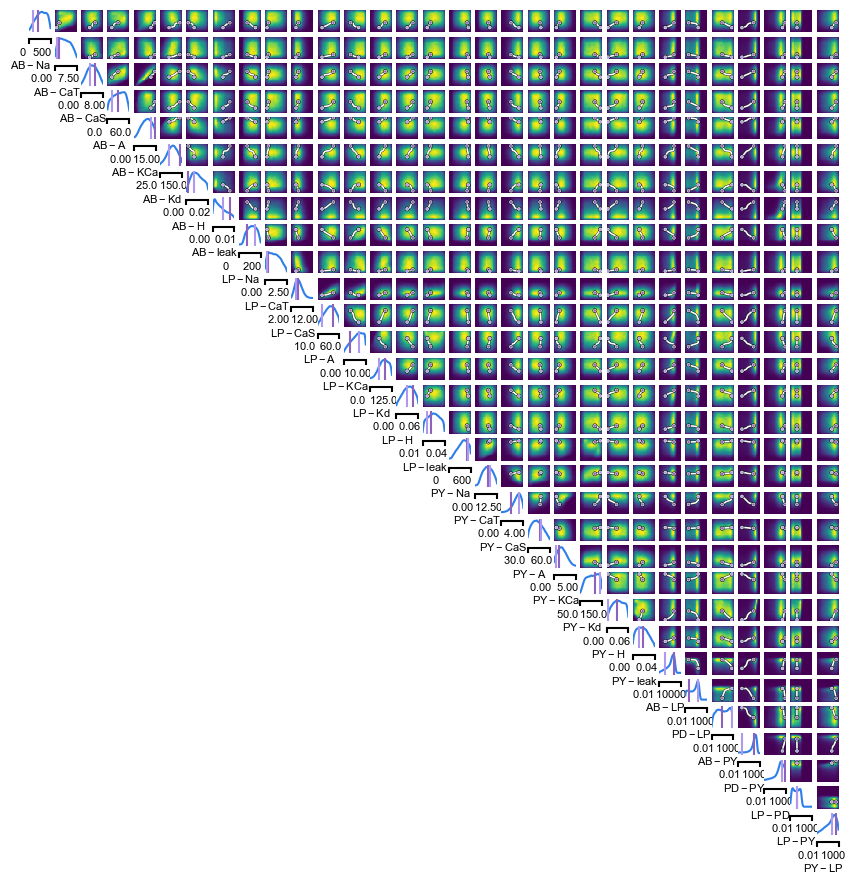

Time 615.181248664856


In [17]:
import matplotlib.patheffects as pe

import time
start_time = time.time()
with mpl.rc_context(fname='../.matplotlibrc'):

    #labels_ = viz.get_labels_8pt(params)
    labels_[9] += ''

    fig, axes = samples_nd(samples=[samples_MAF[:100000], high_p_path.path_coords],
                           #subset=[1,2,3,4,5,6],
                           limits=lims,
                           labelpad=1,
                           tick_labelpad=1,
                           ticks=lims,
                           tick_labels=all_labels,
                           fig_size=(10.45,10.45),
                           labels=labels_,
                           points=[start_point, end_point],
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           points_offdiag={'marker':'o', 'markeredgecolor':'w', 'markersize':2.1, 'markeredgewidth':0.4, 'path_effects':[pe.Stroke(linewidth=1.2, foreground='k'), pe.Normal()]},
                           points_colors=[col['CONSISTENT1'], col['CONSISTENT2']],
                           samples_colors=[col['SNPE'], 'white'],
                           diag=['kde', 'None'],
                           upper=['kde', 'plot'],
                           hist_offdiag={'bins':50},
                           plot_offdiag={'linewidth': 1.2, 'path_effects':[pe.Stroke(linewidth=1.7, foreground='k'), pe.Normal()]})
    
    plt.savefig(PANEL_X, facecolor='None', transparent=True)
    plt.show()
print('Time', time.time()-start_time)

# Appendix: Summary stats along paths

### Load indizes along path at which to evaluate

In [17]:
num_paths = 20  # 3 for faster testing, 20 otherwise
high_p_path_mod = deepcopy(high_p_path)
path_start_positions = np.linspace(0, high_p_path_mod.dists[-1], num_paths)
high_p_indizes = high_p_path_mod.find_closest_index_to_dist(path_start_positions)
indizes_show = high_p_indizes
current_point = high_p_path_mod.path_coords[high_p_indizes]
print(high_p_indizes)

[0, 3, 7, 10, 13, 16, 20, 25, 30, 36, 41, 45, 50, 54, 59, 63, 67, 71, 75, 79]


In [18]:
num_path_pos = num_paths
ortho_path_mod = deepcopy(ortho_path)
path_start_positions = np.linspace(0, ortho_path_mod.dists[-1], num_path_pos)
ortho_p_indizes = ortho_path_mod.find_closest_index_to_dist(path_start_positions)
ortho_p_indizes_show = ortho_p_indizes
#ortho_p_indizes = ortho_p_indizes[:]
print(ortho_p_indizes)

[0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24]


In [19]:
pyloric_sim = netio.create_simulators(params)

out_targets = []
final_indizes = []
for current_ind in indizes_show:
    final_indizes.append(current_ind)

seeds = np.ones_like(final_indizes)
seeds[4] = 2
seeds[6] = 2
    
counter = 0
print('final_indizes', final_indizes)
#for index in final_indizes:
#    target_params = deepcopy(high_p_path.path_coords[int(index)])
#    target_params_sim = target_params * prior.std + prior.mean
#    out_target = pyloric_sim[0].gen_single(deepcopy(target_params_sim), seed_sim=True,
#                                   to_seed=seeds[counter])  # params.true_params gives the synaptic strengths
#    out_targets.append(out_target)
#    counter += 1
#np.savez('results/31D_supplementary/{}simulations_high_p_path.npz'.format(num_paths), out_targets=out_targets)

final_indizes [0, 3, 7, 10, 13, 16, 20, 25, 30, 36, 41, 45, 50, 54, 59, 63, 67, 71, 75, 79]


In [20]:
pyloric_sim = netio.create_simulators(params)

out_targets = []
final_indizes = []
for current_ind in ortho_p_indizes_show:
    final_indizes.append(current_ind)
if seeds is None:
    seeds = np.ones_like(final_indizes)
    
counter = 0
print('final_indizes', final_indizes)
#for index in final_indizes:
#    target_params = deepcopy(ortho_path.path_coords[int(index)])
#    target_params_sim = target_params * prior.std + prior.mean
#    out_target = pyloric_sim[0].gen_single(deepcopy(target_params_sim), seed_sim=True,
#                                   to_seed=seeds[counter])  # params.true_params gives the synaptic strengths
#    out_targets.append(out_target)
#    counter += 1
#np.savez('results/31D_supplementary/{}simulations_ortho_path.npz'.format(num_paths), out_targets=out_targets)

final_indizes [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


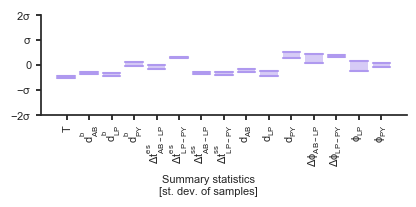

In [23]:
out_targets = np.load('results/31D_supplementary/20simulations_high_p_path.npz', allow_pickle=True)['out_targets']

dimensions_to_use = [0,1,6,7]
with mpl.rc_context(fname='../.matplotlibrc'):
    
    viz.viz_barplots_over_path_v2ss(out_targets=out_targets, posterior_MoG=posterior_MAF, high_p_path=high_p_path_mod, ortho_path=ortho_path_mod, prior=prior, lims=lims, samples=samples_MAF, figsize=(3.5*1.35, 1.3), 
                                          ticks=False, no_contours=True, labels_params=labels_, start_point=high_p_path_mod.start_point, end_point=high_p_path_mod.end_point, current_col='r', mode='13D',
                                          path1=high_p_path_mod.path_coords, path_steps1=1, path2=ortho_path_mod.path_coords, path_steps2=1, dimensions_to_use=dimensions_to_use, show_membrane_conds=[0,1,2,3,4,5],
                                          stat_scale='dataset', stat_mean=stat_mean[:15], stat_std=stat_std[:15], mode_for_membrane_height='high', color_input=col['CONSISTENT2'],
                                          seeds=seeds, indizes=indizes_show, hyperparams=params, date_today='190906', case='high_p', save_fig=False)
    plt.savefig(PANEL_X1ss, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


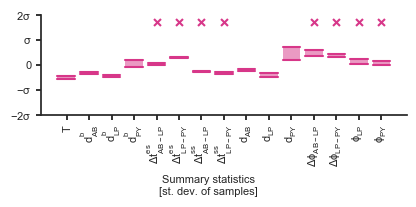

In [24]:
out_targets = np.load('results/31D_supplementary/20simulations_ortho_path.npz', allow_pickle=True)['out_targets']

dimensions_to_use = [0,1,6,7]
with mpl.rc_context(fname='../.matplotlibrc'):

    viz.viz_barplots_over_path_v2ss(out_targets=out_targets, posterior_MoG=posterior_MAF, high_p_path=high_p_path_mod, ortho_path=ortho_path_mod, prior=prior, lims=lims, samples=samples_MAF, figsize=(3.5*1.35, 1.3),
                                          ticks=False, no_contours=True, labels_params=labels_, start_point=high_p_path_mod.start_point, end_point=high_p_path_mod.end_point, current_col='r', mode='13D',
                                          path1=high_p_path_mod.path_coords, path_steps1=1, path2=ortho_path_mod.path_coords, path_steps2=1, dimensions_to_use=dimensions_to_use, show_membrane_conds=[0,1,2,3,4,5],
                                          stat_scale='dataset', stat_mean=stat_mean[:15], stat_std=stat_std[:15], mode_for_membrane_height='high', color_input=col['INCONSISTENT'],
                                          seeds=seeds, indizes=ortho_p_indizes_show, hyperparams=params, date_today='190906', case='ortho_p', save_fig=False)
    plt.savefig(PANEL_X2ss, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

# Appendix: parameters along path

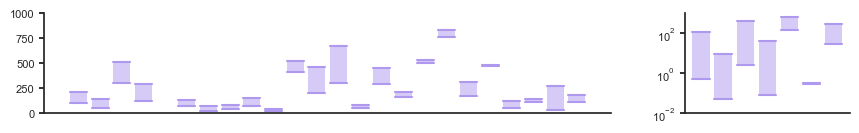

In [25]:
dimensions_to_use = [0,1,6,7]

with mpl.rc_context(fname='../.matplotlibrc'):

    viz.viz_barplots_over_path_v2params(posterior_MoG=posterior_MAF, high_p_path=high_p_path_mod, ortho_path=ortho_path_mod, prior=prior, lims=lims, samples=samples_MAF, figsize=(10.4, 1.3), #(3.6*1.35, 1.6)
                                          ticks=False, no_contours=True, labels_params=labels_, start_point=high_p_path_mod.start_point, end_point=high_p_path_mod.end_point, current_col='r', mode='13D',
                                          path1=high_p_path_mod.path_coords, path_steps1=1, path2=ortho_path_mod.path_coords, path_steps2=1, dimensions_to_use=dimensions_to_use,
                                          stat_mean=None, stat_std=None, stat_scale='experimental', mode_for_membrane_height='high', labels_=False, param_names=False, ss_names=False, color_input=col['CONSISTENT2'],
                                          seeds=seeds, indizes=indizes_show, hyperparams=params, date_today='190906', case='high_p', save_fig=False)
    plt.savefig(PANEL_X1params, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

In [18]:
seeds = [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 2207307, 2207307, 2207307, 2207307, 2207307, 2207307, 2207307,  2207307, 2207307]

dimensions_to_use = [0,1,6,7]

with mpl.rc_context(fname='../.matplotlibrc'):

    viz.viz_barplots_over_path_v2params(posterior_MoG=posterior_MAF, high_p_path=high_p_path_mod, ortho_path=ortho_path_mod, prior=prior, lims=lims, samples=samples_MAF, figsize=(10.4, 1.3), #(3.6*1.35, 1.6)
                                          ticks=False, no_contours=True, labels_params=labels_, start_point=high_p_path_mod.start_point, end_point=high_p_path_mod.end_point, current_col='r', mode='13D',
                                          path1=high_p_path_mod.path_coords, path_steps1=1, path2=ortho_path_mod.path_coords, path_steps2=1, dimensions_to_use=dimensions_to_use,
                                          stat_mean=None, stat_std=None, stat_scale='experimental', mode_for_membrane_height='high', color_input=col['INCONSISTENT'],
                                          seeds=seeds, indizes=ortho_p_indizes_show, hyperparams=params, date_today='190906', case='ortho_p', save_fig=False)
    #plt.savefig(PANEL_X2params, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

NameError: name 'high_p_path_mod' is not defined

# Posterior probability along paths

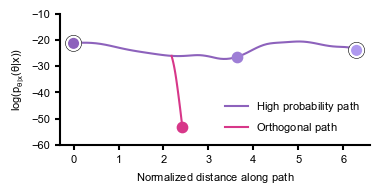

In [73]:
ortho_path_mod = deepcopy(ortho_path)
high_p_path_mod = deepcopy(high_p_path)
#ortho_paths_mod = deepcopy(ortho_paths)

color_mixture = 0.5 * (np.asarray(list(col['CONSISTENT1'])) + np.asarray(list(col['CONSISTENT2'])))

# plots for the samples__
num_cols = 2
num_rows = 5
scale = 'dist' # set this to 'dist' if you want to x-axis to be scale according to the travelled distance
num_steps = num_cols*num_rows
if scale == 'dist':
    steps = np.linspace(0, ortho_path_mod.dists[-1], num_steps)
else:
    steps = np.linspace(0, 1.0, num_steps)
    
with mpl.rc_context(fname='../.matplotlibrc'):
    viz.plot_posterior_over_path(high_p_path_mod, steps, [0], x_axis_scaling=scale, path2=[ortho_path_mod],
                             title='Comparison of the posterior probability along the paths', normalize_yaxis=False, cols=[col['CONSISTENT1'], col['CONSISTENT2'], color_mixture, col['INCONSISTENT']],
                             xval_ortho_start=[ortho_path.start_point_ind], case='comp2', date_today=date_today, x_axis_labels=True, use_sns=True, save_fig=False)

    plt.savefig(PANEL_Y, facecolor='None', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()

# Assemble figure

In [50]:
color_mixture = 0.5 * (np.asarray(list(col['CONSISTENT1'])) + np.asarray(list(col['CONSISTENT2'])))

In [48]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

### Supplementary posterior

In [20]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

f = Figure("20.3cm", "21.5cm",

    Panel(
          SVG(PANEL_X).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
    ).move(11*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("fig/fig8_stg_31Dexperimental_supp_posterior.svg")
svg('fig/fig8_stg_31Dexperimental_supp_posterior.svg')

### Supplementary rest

In [19]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text ={'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '12pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '12pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '12pt', 'font': 'Arial', 'weight': '500', 'color': '#D73789'}


f = Figure("20.3cm", "14.95cm",

   Panel(
          SVG(PANEL_X1ss).scale(svg_scale).move(0, 10),
          SVG(PANEL_X2ss).scale(svg_scale).move(400, 10),
          Text("a", -5, 16, **kwargs_text),
          Text("b", 395, 16, **kwargs_text),
    ).move(5, -3),
           
    Panel(
          SVG(PANEL_X1params).scale(svg_scale),
          Text("c", 0, 0, **kwargs_text),
    ).move(0,200),
    
   Panel(
          SVG(PANEL_X2params).scale(svg_scale),
          Text("d", 0, 0, **kwargs_text),
    ).move(0,330),
)

!mkdir -p fig
f.save("fig/fig8_stg_31Dexperimental_supp_hists.svg")
svg('fig/fig8_stg_31Dexperimental_supp_hists.svg')

### Supplementary probability along path

In [74]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#D73789'}

f = Figure("20.3cm", "4.3cm",

    Panel(
        SVG(PANEL_Y).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
        Text("1", 27.2*factor_svg, 7.3*factor_svg, **kwargs_consistent1),
        Text("2", 16.1*factor_svg, 21.7*factor_svg, **kwargs_inconsistent),
    ).move(11*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("fig/fig8_stg_31Dexperimental_supp_probAlongPath.svg")
svg('fig/fig8_stg_31Dexperimental_supp_probAlongPath.svg')